In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()
# sns.set(rc={'axes.facecolor':'black'})
import pandas as pd
import mne
from sklearn.metrics import confusion_matrix, accuracy_score
from brainda.algorithms.utils.model_selection import (
    set_random_seeds, 
    generate_loo_indices, match_loo_indices)
from brainda.algorithms.decomposition import (
    FBTRCA, FBTDCA, FBSCCA, FBECCA, FBDSP,
    generate_filterbank, generate_cca_references)
from collections import OrderedDict
from sklearn.pipeline import clone
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
import sys, time
from matplotlib.colors import LogNorm

In [109]:
def load_egg(eeg, meta, classes, stim_duration=5, sfreq=300, filter=True, drop_chan=['time',' TRG',' X1',' X2',' X3',' A2']):
    trials = meta[1:,:2]
    times = []
    duration_samples = int(stim_duration*sfreq)
    for index, row in eeg.loc[eeg[' TRG']==16.0].iterrows():
        if index > 0 and eeg.iloc[index-1][' TRG'] == 0 and (not eeg.iloc[index:index+duration_samples][' TRG'].isin([18.0]).any()):
            times.append(row['time'])
    times = np.array(times)
    
    # eeg = np.array([eeg.loc[eeg['time']>=t].drop(columns=drop_chan).to_numpy()[:duration_samples].T for t in times])
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=drop_chan).to_numpy()[:duration_samples].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=sfreq, l_freq=5, h_freq=49, verbose=0, method='fir')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

def load_dataset(path="../data/eeg_recordings/32-class_speller/DSI-24/Simon2/",
                sub_dirs=['_run1/'],
                drop_chan=['time',' TRG',' X1',' X2',' X3',' A2'],
                duration=1.5,
                n_trials=2,
                n_classes=32,
                sfreq=300):
    n_channels = 25 - len(drop_chan)
    # load experimental dataset
    eeg_whole = np.zeros((n_trials*len(sub_dirs),n_classes,n_channels,int(duration*sfreq)))
    target_tab = {}
    for i_dir,sub_dir in enumerate(tqdm(sub_dirs, desc='Loading Data...', leave=False, file=sys.stdout)):
        data_path = path + sub_dir
        eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
        meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
        trials = meta[1:,:2]
        classes = np.unique(trials, axis=0)
        more_targets = {tuple(target):index for index,target in enumerate(classes)}
        target_tab.update(more_targets)
        eeg = load_egg(eeg, meta, classes, stim_duration=duration,filter=False,drop_chan=drop_chan)
        eeg_whole[i_dir*n_trials:(i_dir+1)*n_trials,:,:,:] = eeg
    eeg = eeg_whole
    target_by_trial = [list(target_tab.keys())] * n_trials*len(sub_dirs)
    print('\r', end='')
    print(eeg.shape, np.array(target_by_trial).shape)
    return eeg, target_by_trial, target_tab

def load_np_dataset(path="../data/eeg_recordings/32-class_speller/DSI-24/Simon2/",
                sub_dirs=['run1/','run2/','run3/','run4/'],):
    for i_dir,sub_dir in enumerate(tqdm(sub_dirs, desc='Loading Data...', leave=False, file=sys.stdout)):
        data_path = path + sub_dir
        if i_dir == 0:
            with open(data_path + 'eeg.npy', 'rb') as f:
                eeg_np = np.load(f)
        else:
            with open(data_path + 'eeg.npy', 'rb') as f:
                new_eeg_np = np.load(f)
            eeg_np = np.concatenate((eeg_np, new_eeg_np))
    return eeg_np

def cm_graph(cm, acc):
    plt.figure(figsize=(7, 6))
    # ax = sns.heatmap(confusion_matrix(testYs, pred_Ys, normalize='true'), cmap='Blues_r', norm=LogNorm())
    ax = sns.heatmap(cm, cmap='Blues_r', norm=LogNorm())
    # ax.set_title('val acc: '+str(accuracy_score(testYs, pred_Ys)));
    ax.set_title('loo acc: '+str(acc));
    ax.set_xticks(range(32))
    ax.set_yticks(range(32))
    ax.xaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = -90);
    ax.yaxis.set_ticklabels([str(e) for e in list(target_tab.keys())],rotation = 0);
    ax.hlines([4,8,12,16,20,24,28], *ax.get_xlim())
    ax.vlines([4,8,12,16,20,24,28], *ax.get_xlim())
    plt.show()

def cm_32_graph(conf_matrices, accuracies,lognorm=False):
    fig,axs = plt.subplots(5,6,figsize=(20, 17), sharex='col', sharey='row')
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    for i in range(5):
        for j in range(6):
            if lognorm:
                g = sns.heatmap(conf_matrices[i,j],cmap="Blues_r",ax=axs[i,j], cbar_ax=cbar_ax, norm=LogNorm())
            else:
                g = sns.heatmap(conf_matrices[i,j],cmap="Blues_r",ax=axs[i,j], cbar_ax=cbar_ax)
            g.set_ylabel('')
            g.set_xlabel('')
            g.set_title('loo acc: '+str(accuracies[i,j]));
            g.hlines([4,8,12,16,20,24,28], *g.get_xlim())
            g.vlines([4,8,12,16,20,24,28], *g.get_xlim())

def run_fbtdca(eeg, target_by_trial, target_tab, duration=1.0, onset_delay=42,srate=300, return_prob=True):
    eeg = np.copy(eeg)
    np.random.seed(64)
    np.random.shuffle(eeg)
    n_trials = eeg.shape[0]
    classes = range(32)
    n_classes = len(classes)
    prob_matrix=np.zeros((n_classes,n_classes))
    y = np.array([list(target_tab.values())] * n_trials).T.reshape(-1)
    eeg_temp = eeg[:n_trials,classes,:,onset_delay:]
    X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])


    freq_targets = np.array(target_by_trial)[0,:,0]
    phase_targets = np.array(target_by_trial)[0,:,1]
    n_harmonics = 5
    n_bands = 3
    Yf = generate_cca_references(
        freq_targets, srate, duration, 
        phases=phase_targets, 
        n_harmonics=n_harmonics)
    wp = [[8*i, 90] for i in range(1, n_bands+1)]
    ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
    filterbank = generate_filterbank(
        wp, ws, srate, order=4, rp=1)
    filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
    set_random_seeds(64)
    l = 5
    models = OrderedDict([
        ('fbtdca', FBTDCA(
                filterbank, l, n_components=8, 
                filterweights=filterweights)),
    ])
    events = []
    for j_class in classes:
        events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(n_trials)])
    events = np.array(events)
    subjects = ['1'] * (n_classes*n_trials)
    meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
    set_random_seeds(42)
    loo_indices = generate_loo_indices(meta)

    for model_name in models:
        if model_name == 'fbtdca':
            filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
        else:
            filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
        
        filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

        n_loo = len(loo_indices['1'][events[0]])
        loo_accs = []
        testYs = []
        pred_labelss = []
        for k in range(n_loo):
            train_ind, validate_ind, test_ind = match_loo_indices(
                k, meta, loo_indices)
            train_ind = np.concatenate([train_ind, validate_ind])

            trainX, trainY = filterX[train_ind], filterY[train_ind]
            testX, testY = filterX[test_ind], filterY[test_ind]

            model = clone(models[model_name]).fit(
                trainX, trainY,
                Yf=Yf
            )
            if return_prob:
                prob_matrix+=model.transform(testX)
            pred_labels = model.predict(testX)
            loo_accs.append(
                balanced_accuracy_score(testY, pred_labels))
            pred_labelss.extend(pred_labels)
            testYs.extend(testY)
        
    if return_prob:
        return prob_matrix, accuracy_score(testYs, pred_labelss)
    return confusion_matrix(testYs, pred_labelss, normalize='true'), accuracy_score(testYs, pred_labelss)

def run_fbtrca(eeg, target_by_trial, target_tab, duration=1.0, onset_delay=42,srate=300, return_prob=True):
    eeg = np.copy(eeg)
    np.random.seed(64)
    np.random.shuffle(eeg)
    n_trials = eeg.shape[0]
    classes = range(32)
    n_classes = len(classes)
    prob_matrix=np.zeros((n_classes,n_classes))
    y = np.array([list(target_tab.values())] * n_trials).T.reshape(-1)
    eeg_temp = eeg[:n_trials,classes,:,onset_delay:]
    X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])


    freq_targets = np.array(target_by_trial)[0,:,0]
    phase_targets = np.array(target_by_trial)[0,:,1]
    n_harmonics = 5
    n_bands = 3
    Yf = generate_cca_references(
        freq_targets, srate, duration, 
        phases=phase_targets, 
        n_harmonics=n_harmonics)
    wp = [[8*i, 90] for i in range(1, n_bands+1)]
    ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
    filterbank = generate_filterbank(
        wp, ws, srate, order=4, rp=1)
    filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
    set_random_seeds(64)
    l = 5
    models = OrderedDict([
        ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ])
    events = []
    for j_class in classes:
        events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(n_trials)])
    events = np.array(events)
    subjects = ['1'] * (n_classes*n_trials)
    meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
    set_random_seeds(42)
    loo_indices = generate_loo_indices(meta)

    for model_name in models:
        if model_name == 'fbtdca':
            filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
        else:
            filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
        
        filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

        n_loo = len(loo_indices['1'][events[0]])
        loo_accs = []
        testYs = []
        pred_labelss = []
        for k in range(n_loo):
            train_ind, validate_ind, test_ind = match_loo_indices(
                k, meta, loo_indices)
            train_ind = np.concatenate([train_ind, validate_ind])

            trainX, trainY = filterX[train_ind], filterY[train_ind]
            testX, testY = filterX[test_ind], filterY[test_ind]

            model = clone(models[model_name]).fit(
                trainX, trainY,
                Yf=Yf
            )
            if return_prob:
                prob_matrix+=model.transform(testX)
            pred_labels = model.predict(testX)
            loo_accs.append(
                balanced_accuracy_score(testY, pred_labels))
            pred_labelss.extend(pred_labels)
            testYs.extend(testY)
        
    if return_prob:
        return prob_matrix, accuracy_score(testYs, pred_labelss)
    return confusion_matrix(testYs, pred_labelss, normalize='true'), accuracy_score(testYs, pred_labelss)

In [97]:
eeg, target_by_trial, target_tab = load_dataset()

(2, 32, 19, 450) (2, 32, 2)                                   


In [121]:
target_tab

{(8.0, 0.0): 0,
 (8.0, 0.5): 1,
 (8.0, 1.0): 2,
 (8.0, 1.5): 3,
 (9.0, 0.0): 4,
 (9.0, 0.5): 5,
 (9.0, 1.0): 6,
 (9.0, 1.5): 7,
 (10.0, 0.0): 8,
 (10.0, 0.5): 9,
 (10.0, 1.0): 10,
 (10.0, 1.5): 11,
 (11.0, 0.0): 12,
 (11.0, 0.5): 13,
 (11.0, 1.0): 14,
 (11.0, 1.5): 15,
 (12.0, 0.0): 16,
 (12.0, 0.5): 17,
 (12.0, 1.0): 18,
 (12.0, 1.5): 19,
 (13.0, 0.0): 20,
 (13.0, 0.5): 21,
 (13.0, 1.0): 22,
 (13.0, 1.5): 23,
 (14.0, 0.0): 24,
 (14.0, 0.5): 25,
 (14.0, 1.0): 26,
 (14.0, 1.5): 27,
 (15.0, 0.0): 28,
 (15.0, 0.5): 29,
 (15.0, 1.0): 30,
 (15.0, 1.5): 31}

In [111]:
eeg_np = load_np_dataset()
eeg_np.shape

(8, 32, 19, 360)

In [114]:
eeg = np.concatenate((eeg[:,:,:,42:42+360],eeg_np))
eeg.shape

(10, 32, 19, 360)

In [128]:
run_fbtdca(eeg, [target_by_trial[0]*5], target_tab, duration=1.0, onset_delay=0,srate=300, return_prob=True)

IndexError: list index out of range

In [126]:
[target_by_trial[0]*5]

[[(8.0, 0.0),
  (8.0, 0.5),
  (8.0, 1.0),
  (8.0, 1.5),
  (9.0, 0.0),
  (9.0, 0.5),
  (9.0, 1.0),
  (9.0, 1.5),
  (10.0, 0.0),
  (10.0, 0.5),
  (10.0, 1.0),
  (10.0, 1.5),
  (11.0, 0.0),
  (11.0, 0.5),
  (11.0, 1.0),
  (11.0, 1.5),
  (12.0, 0.0),
  (12.0, 0.5),
  (12.0, 1.0),
  (12.0, 1.5),
  (13.0, 0.0),
  (13.0, 0.5),
  (13.0, 1.0),
  (13.0, 1.5),
  (14.0, 0.0),
  (14.0, 0.5),
  (14.0, 1.0),
  (14.0, 1.5),
  (15.0, 0.0),
  (15.0, 0.5),
  (15.0, 1.0),
  (15.0, 1.5),
  (8.0, 0.0),
  (8.0, 0.5),
  (8.0, 1.0),
  (8.0, 1.5),
  (9.0, 0.0),
  (9.0, 0.5),
  (9.0, 1.0),
  (9.0, 1.5),
  (10.0, 0.0),
  (10.0, 0.5),
  (10.0, 1.0),
  (10.0, 1.5),
  (11.0, 0.0),
  (11.0, 0.5),
  (11.0, 1.0),
  (11.0, 1.5),
  (12.0, 0.0),
  (12.0, 0.5),
  (12.0, 1.0),
  (12.0, 1.5),
  (13.0, 0.0),
  (13.0, 0.5),
  (13.0, 1.0),
  (13.0, 1.5),
  (14.0, 0.0),
  (14.0, 0.5),
  (14.0, 1.0),
  (14.0, 1.5),
  (15.0, 0.0),
  (15.0, 0.5),
  (15.0, 1.0),
  (15.0, 1.5),
  (8.0, 0.0),
  (8.0, 0.5),
  (8.0, 1.0),
  (8.0, 1.5),


In [ ]:
with open('../eeg.npy', 'rb') as f:
    eeg_np = np.load(f)

In [103]:
with open('../data/eeg_recordings/32-class_speller/DSI-24/Simon2/_run1/eeg.npy', 'rb') as f:
    eeg_np = np.load(f)

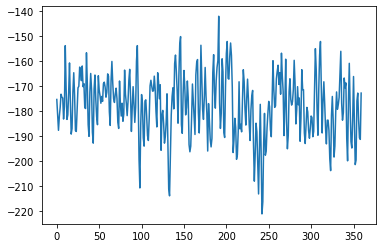

In [82]:
eeg_np.shape

(2, 32, 19, 360)

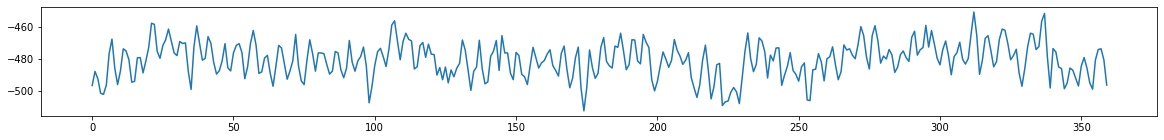

In [83]:
plt.figure(figsize=(20,2))
plt.plot(eeg_np[0,0,0])

In [84]:
eeg, target_by_trial, target_tab = load_dataset(path="../",sub_dirs=[''],duration=1.34)

(2, 32, 19, 402) (2, 32, 2)                                   


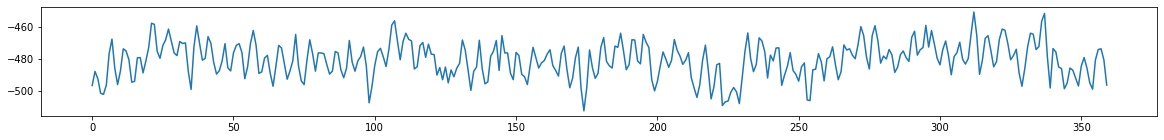

In [85]:
plt.figure(figsize=(20,2))
plt.plot(eeg[0,0,0,42:])

In [86]:
import pickle
with open("../reports/trained_models/32-class_speller/DSI-24/Simon/fbtdca_1s.pkl", 'rb') as filehandler:
    model = pickle.load(filehandler)

In [87]:
np_pred = model.predict(eeg_np[:,:,:,:310])

In [88]:
csv_pred=model.predict(eeg[:,:,:,42:352])

In [89]:
accuracy_score(np_pred, np.array(list(range(32))*2))

0.59375

In [90]:
accuracy_score(csv_pred, np.array(list(range(32))*2))

0.59375